# Import Libraries 

In [71]:
import functools
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import optuna 
import pandas as pd
import pickle
import re
import seaborn as sns
import usaddress
import xgboost as xgb

from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import auc, recall_score,precision_score,confusion_matrix,f1_score,average_precision_score,roc_auc_score,roc_curve,brier_score_loss
from sklearn.model_selection import KFold, StratifiedKFold,train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [3]:
credit_data=pd.read_csv("credit_data.csv")
print(credit_data.shape)

(45222, 21)


## Summary Of Columns 

In [4]:
def columns_summary(input_df):
    summary_dict={}
    for col in input_df.columns:
        summary_dict[col]={}
        summary_dict[col]["# Unique Values"]=input_df[col].nunique()
        summary_dict[col]["5 Point Summary "]=dict(input_df[col].describe())
        summary_dict[col]['Percentage of Nulls']=str(input_df[col].isnull().sum()/len(input_df[col])*100)+str("%")
        summary_dict[col]["Top Values"]=input_df[col].value_counts().index.tolist()
    
    return pd.DataFrame(summary_dict).T

In [5]:
summary_df=columns_summary(credit_data)
display(summary_df)

,# Unique Values,5 Point Summary,Percentage of Nulls,Top Values
user_id,45222,"{'count': 45222, 'unique': 45222, 'top': '307c...",0.0%,"[307c73a3-0c67-43b5-b0d1-62ad5f00b52a, fa16841..."
gender,2,"{'count': 45222, 'unique': 2, 'top': ' Male', ...",0.0%,"[ Male, Female]"
date_of_birth,74,"{'count': 45222, 'unique': 74, 'top': '1984-01...",0.0%,"[1984-01-04, 1987-01-03, 1989-01-02, 1985-01-0..."
workclass,7,"{'count': 45222, 'unique': 7, 'top': ' Private...",0.0%,"[ Private, Self-emp-not-inc, Local-gov, Sta..."
education_level,16,"{'count': 45222, 'unique': 16, 'top': ' HS-gra...",0.0%,"[ HS-grad, Some-college, Bachelors, Masters..."
education_num,16,"{'count': 45222.0, 'mean': 10.118460041572686,...",0.0%,"[9.0, 10.0, 13.0, 14.0, 11.0, 7.0, 12.0, 6.0, ..."
marital_status,7,"{'count': 45222, 'unique': 7, 'top': ' Married...",0.0%,"[ Married-civ-spouse, Never-married, Divorce..."
occupation,14,"{'count': 45222, 'unique': 14, 'top': ' Craft-...",0.0%,"[ Craft-repair, Prof-specialty, Exec-manager..."
relationship,6,"{'count': 45222, 'unique': 6, 'top': ' Husband...",0.0%,"[ Husband, Not-in-family, Own-child, Unmarr..."
capital_gain,121,"{'count': 45222.0, 'mean': 1101.4303436380524,...",0.0%,"[0.0, 15024.0, 7688.0, 7298.0, 99999.0, 3103.0..."


<b>We observe that most of columns have 100% fill rate except the following </b>

1) Inquiry Purpose Code <br>
2) Asset Class CD (Very high % of nulls) <br>
3) Asset Code <br>
4) Portfolio Type <br>

# Checking Target Distribution 

In [6]:
credit_data['approved'].value_counts()

approved
0    34014
1    11208
Name: count, dtype: int64

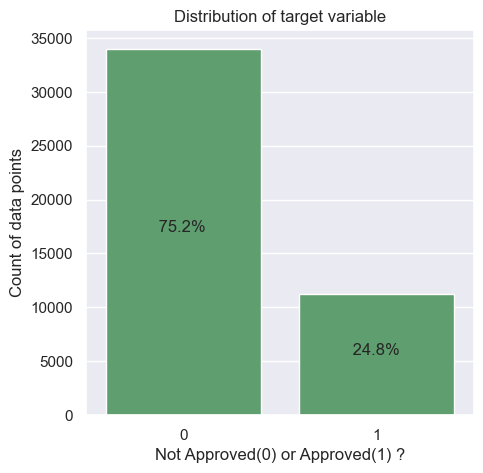

In [7]:
sns.set(rc={'figure.figsize':(5,5)})
ax = sns.countplot(credit_data,x='approved', color="g")
total = len(credit_data['approved'])*1
plt.title("Distribution of target variable")
plt.xlabel("Not Approved(0) or Approved(1) ?")
plt.ylabel("Count of data points") 
for p in ax.patches:
        ax.annotate('{: .1f}%'.format(100*p.get_height()/total), (p.get_x()+0.25, p.get_height()/2))


<b>We observe that around 25% of the application gets approved and it is clear from above graph that it is not suffering from any kind of imbalance data

# Distribution Of Target Per Gender 

[20988.0, 13026.0, 9539.0, 1669.0, 0, 0]


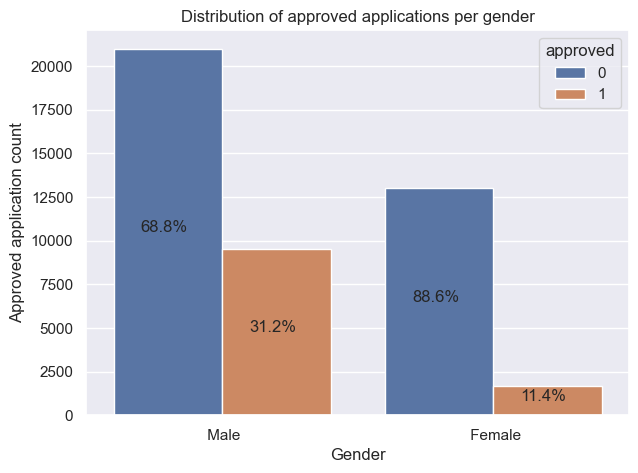

In [8]:
sns.set(rc={'figure.figsize':(7,5)})
credit_data['gender'] = pd.Categorical(credit_data['gender'],
                                   categories=[' Male',' Female'],
                                   ordered=True)
ax = sns.countplot(credit_data, x='gender',hue=credit_data['approved'])
Number_of_categories=credit_data['gender'].nunique()
hue_categories=credit_data['approved'].nunique()
a = [p.get_height() for p in ax.patches]
print(a)
patch = [p for p in ax.patches]
for i in range(Number_of_categories):
    total = credit_data['gender'].value_counts().values[i]
    
    for j in range(hue_categories):
        percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
        x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2-0.1
        y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height()/2 
        ax.annotate(percentage, (x, y), size = 12)
plt.title("Distribution of approved applications per gender")
plt.xlabel("Gender")
plt.ylabel("Approved application count") 
plt.show()

We observe that percentage of approved application among males are significantly higher than females. Even though it can be a good predictior for model, <b> We should not use it as a feature other wise it will be a gender biased model </b>

# Extracting Age From Date Of Birth Column

In [9]:
credit_data['date_of_birth'] = pd.to_datetime(credit_data['date_of_birth'])
today_date  = pd.to_datetime(datetime.today().strftime("%Y-%m-%d"))


In [10]:
credit_data['age_of_applicant']=credit_data['date_of_birth'].apply(lambda x : int((today_date-x).days/365))

# Capping Outliers 

In [11]:
def iqr_cap_outliers(series, iqr_threshold=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lbound = Q1 - iqr_threshold * IQR
    ubound = Q3 + iqr_threshold * IQR

    outliers = (series < lbound) | (series > ubound)

    series = series.copy()
    series.loc[series < lbound] = series.loc[~outliers].min()
    series.loc[series > ubound] = series.loc[~outliers].max()

    return series

In [12]:
display(credit_data['age_of_applicant'].describe())
credit_data['age_of_applicant']=iqr_cap_outliers(credit_data['age_of_applicant'])
display(credit_data['age_of_applicant'].describe())


count    45222.000000
mean        42.547941
std         13.217870
min         21.000000
25%         32.000000
50%         41.000000
75%         51.000000
max         94.000000
Name: age_of_applicant, dtype: float64

count    45222.000000
mean        42.511698
std         13.103689
min         21.000000
25%         32.000000
50%         41.000000
75%         51.000000
max         79.000000
Name: age_of_applicant, dtype: float64

## Relation Between Age And Approval Of Application

In [13]:
credit_data['age_bins']=pd.cut(credit_data['age_of_applicant'],[10,25,30,35,40,45,50,55,60,100])

In [14]:
approval_percentage_per_age_bin=credit_data.groupby(['age_bins'])['approved'].mean().reset_index()

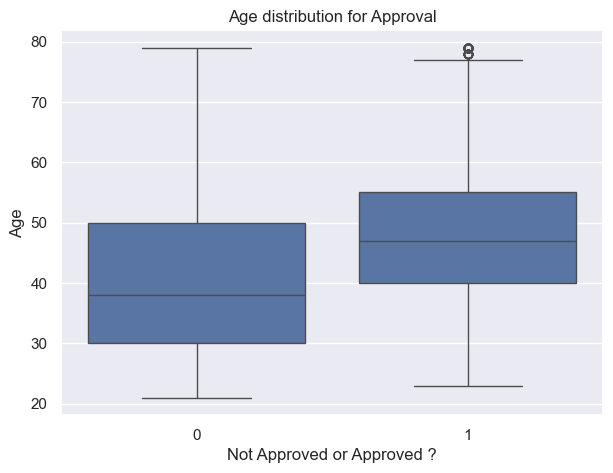

In [15]:
ax=sns.boxplot(data=credit_data, y="age_of_applicant",x="approved")
plt.title("Age distribution for Approval")
plt.ylabel("Age")
plt.xlabel("Not Approved or Approved ?") 
plt.show()

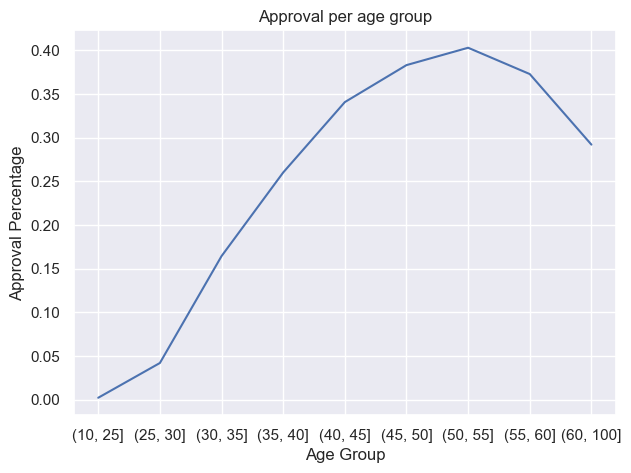

In [20]:
approval_percentage_per_age_bin['age_bins']=approval_percentage_per_age_bin['age_bins'].astype(str)
approval_percentage_per_age_bin['approved'] = approval_percentage_per_age_bin['approved'].astype(float)
sns.lineplot(approval_percentage_per_age_bin,x="age_bins", y='approved', err_style="bars")
plt.title("Approval per age group")
plt.ylabel("Approval Percentage")
plt.xlabel("Age Group") 
plt.show()


<b>We observe that as age group increases there is a increase in overall approval of applications but after the age of 55 it starts reducing it may be because of retirement age and earning capacity getting reduced 

# Approval Rate For Different Work-Class

In [21]:
def generatePlots(df,column_name,target_column,color,rotation,labels="percentage"):
    sns.set(rc={'figure.figsize':(12,5)})
    plot_df=df.groupby(column_name)[target_column].mean().reset_index()
    ax = sns.barplot(plot_df,x=column_name,y=target_column, color=color)
    total = len(df)*1
    plt.title(str(target_column.replace("_"," ").title())+" Vs "+str(column_name.replace("_"," ").title()))
    plt.xlabel(str(column_name.replace("_"," ").title()))
    plt.ylabel(str(target_column.replace("_"," ").title())) 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)
    
    for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            if labels=="percentage":
                value = '{:.2f}'.format(p.get_height()*100)
                ax.text(_x, _y, str(value)+str("%"), ha="center") 
            else:
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, str(value), ha="center")
                
                


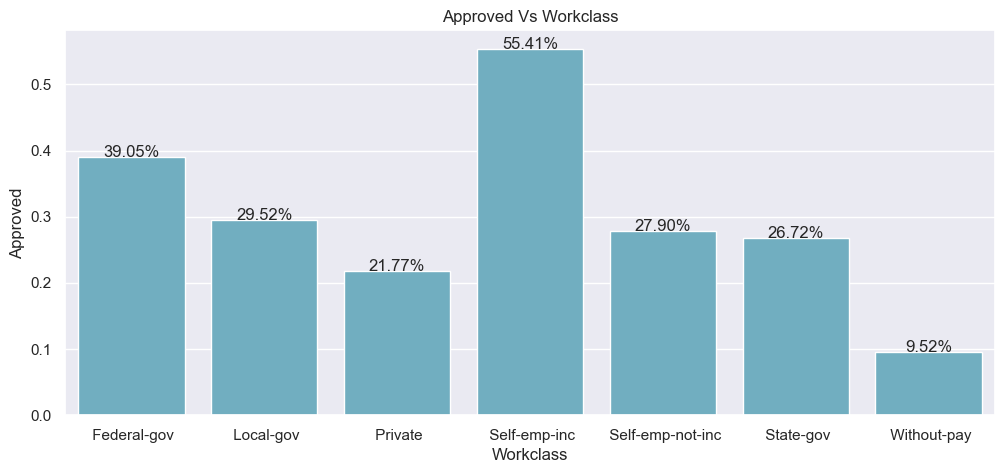

In [22]:
generatePlots(credit_data.copy(),"workclass","approved","c",0)

<b>We observe that Self Employed people have highest approval percentage and without pay people have least approval rate

<b>Without pay workcalss user id "dfc97023-6a51-4abb-ab5a-93a771ed8e83"  and "4f40d259-f836-4c02-b61a-60c040277246" are having positive capital gain is it possible or is it an anomaly ?

# Approval Rate For Different Education Level 

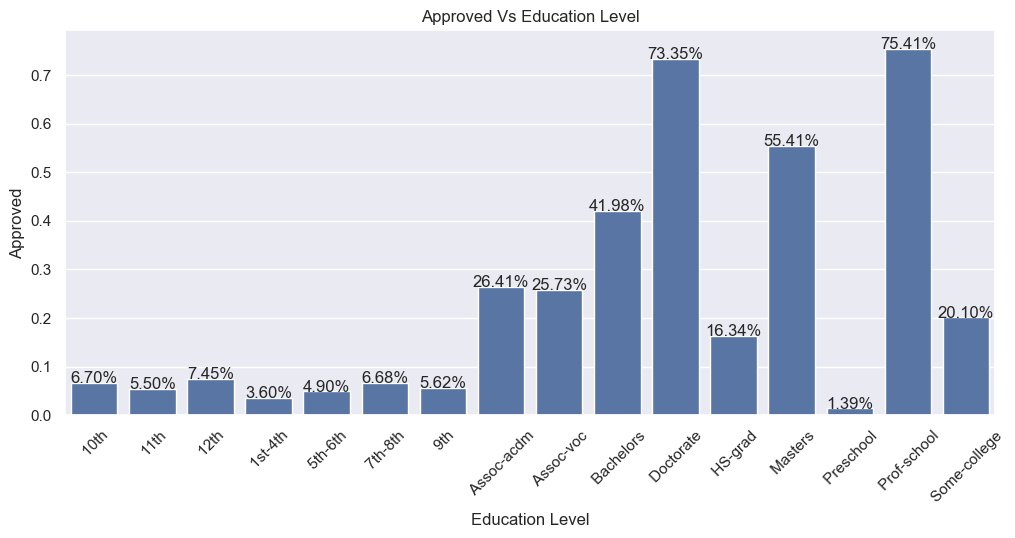

In [23]:
generatePlots(credit_data.copy(),"education_level","approved","b",45)

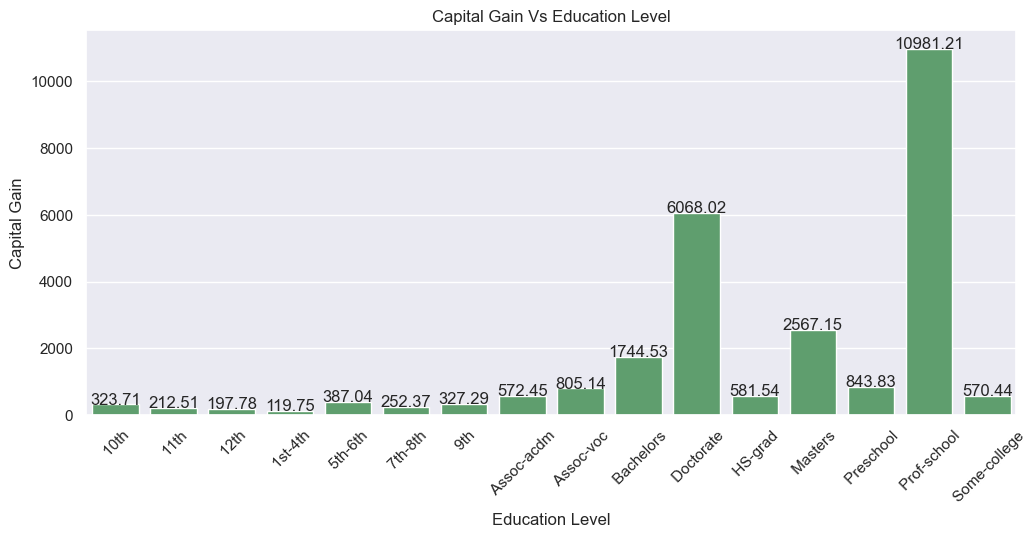

In [24]:
generatePlots(credit_data.copy(),"education_level","capital_gain","g",45,None)
# credit_data.groupby(['education_level'])['capital_gain'].mean()

<b>We observe as the person has higher degree there is a better chance of application getting approved highest among Prof-School, and this is because we have highest capital gains in almost same order i.e. highest for Prof-School & Doctorates

# Education Level & Education Number relation 

In [25]:
pd.crosstab(credit_data['education_level'],credit_data['education_num'])

education_num,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
education_level,,,,,,,,,,,,,,,,
10th,0,0,0,0,0,1223,0,0,0,0,0,0,0,0,0,0
11th,0,0,0,0,0,0,1619,0,0,0,0,0,0,0,0,0
12th,0,0,0,0,0,0,0,577,0,0,0,0,0,0,0,0
1st-4th,0,222,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5th-6th,0,0,449,0,0,0,0,0,0,0,0,0,0,0,0,0
7th-8th,0,0,0,823,0,0,0,0,0,0,0,0,0,0,0,0
9th,0,0,0,0,676,0,0,0,0,0,0,0,0,0,0,0
Assoc-acdm,0,0,0,0,0,0,0,0,0,0,0,1507,0,0,0,0
Assoc-voc,0,0,0,0,0,0,0,0,0,0,1959,0,0,0,0,0


<b> Observations:<br> 
    We can clearly see there is one to one mapping for education level and eucation number, thus the two columns will provide similar information to the models 

# Approval Rate Per Marital Status

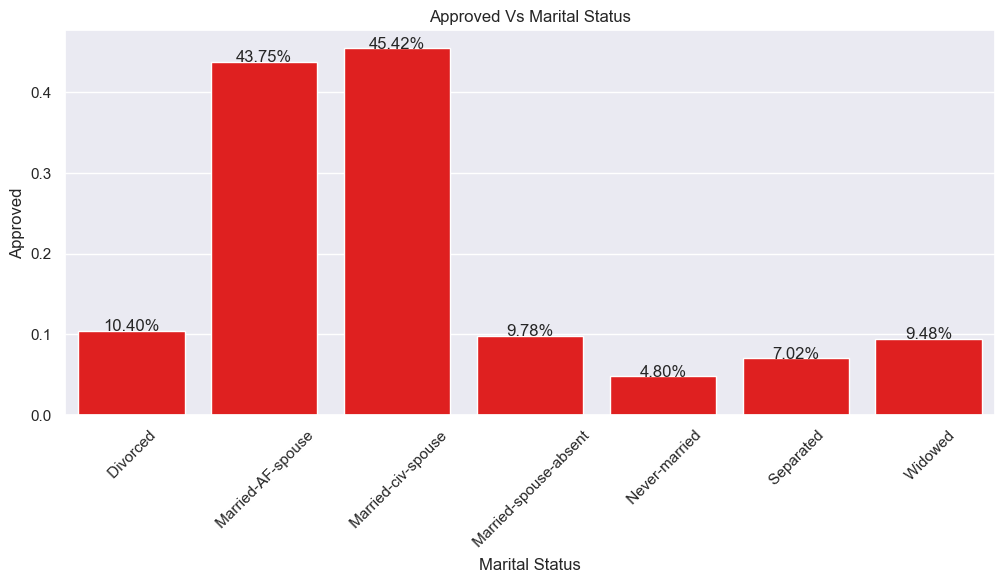

In [26]:
generatePlots(credit_data.copy(),"marital_status","approved","red",45)
# credit_data.groupby(['education_level'])['capital_gain'].mean()

<b> Married people with spouse are having very high approval rate it may be because of better financial stability 

# Approval Rate For Different Occupation

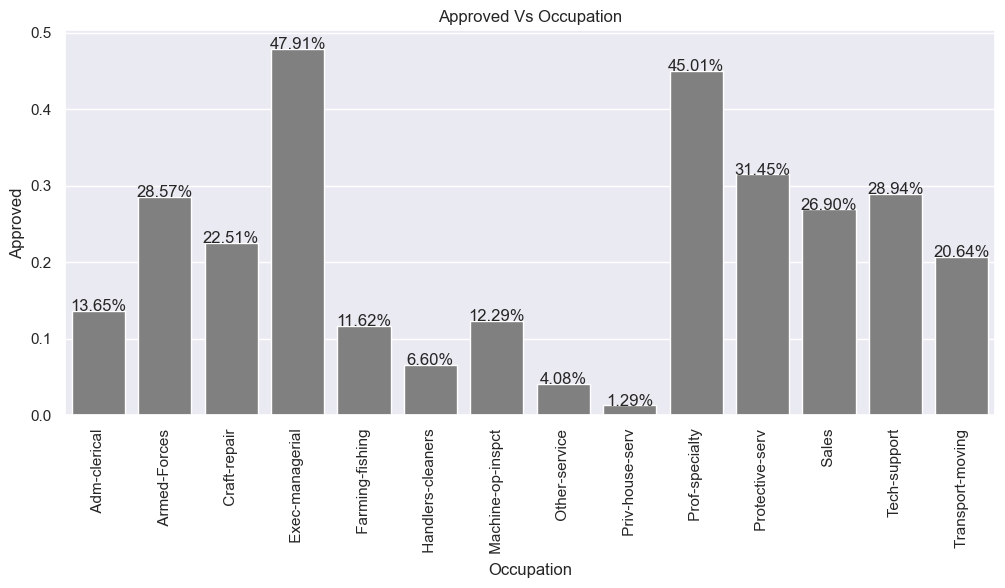

In [27]:
generatePlots(credit_data.copy(),"occupation","approved","grey",90)

<b>Professors and Managers are having a very high approval rate as compared to other occupations 

# Approval Rate For Different Relationship Status

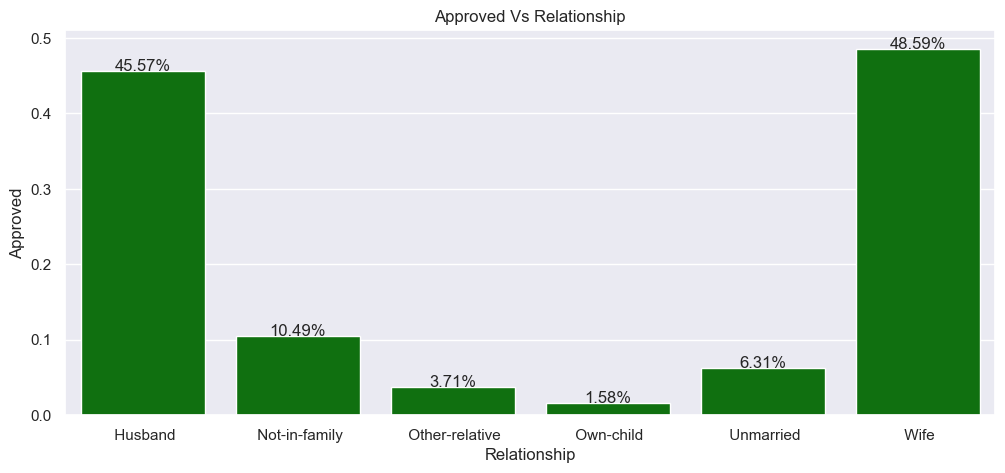

In [28]:
generatePlots(credit_data.copy(),"relationship","approved","green",0)
# credit_data.groupby(['education_level'])['capital_gain'].mean()

<b>We can observe here that as seen in EDA summaries on Marital Status, Husband and Wife is having a lot of approval rate 

# Captail Gain and Capital Loss 

In [29]:
credit_data['capital_gain_bins']=pd.cut(credit_data['capital_gain'],10)
capital_gain_buckets=credit_data.groupby(['capital_gain_bins'])['approved'].mean().reset_index()

In [30]:
credit_data['capital_loss_bins']=pd.cut(credit_data['capital_loss'],10)
capital_loss_buckets=credit_data.groupby(['capital_loss_bins'])['approved'].mean().reset_index()

In [31]:
#### Creating net capital by subtracting loss from gain 
credit_data['capital_profit']=credit_data['capital_gain']-credit_data['capital_loss']
#### Getting if net capital is more than 0
credit_data['capital_is_zero']=(credit_data['capital_profit']==0).astype(int)

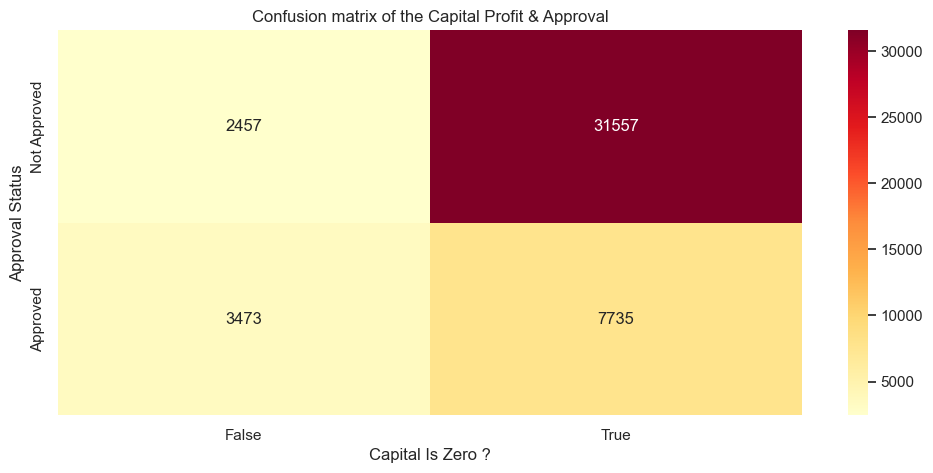

In [32]:
labels = ['Not Approved', 'Approved']
cm = confusion_matrix(credit_data['approved'],credit_data['capital_is_zero'])
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap="YlOrRd")
ax.set_ylabel('Approval Status');ax.set_xlabel('Capital Is Zero ?'); 
ax.set_title('Confusion matrix of the Capital Profit & Approval'); 
ax.yaxis.set_ticklabels(['Not Approved', 'Approved']); ax.xaxis.set_ticklabels(['False', 'True']);

<b>Observations :
1) More than 50% of the applications where capital gain is more than 0, has approval status <br>
2) The application with 0 capital gain is having more number of not approved applications

# Hours Per Week Vs Approved 

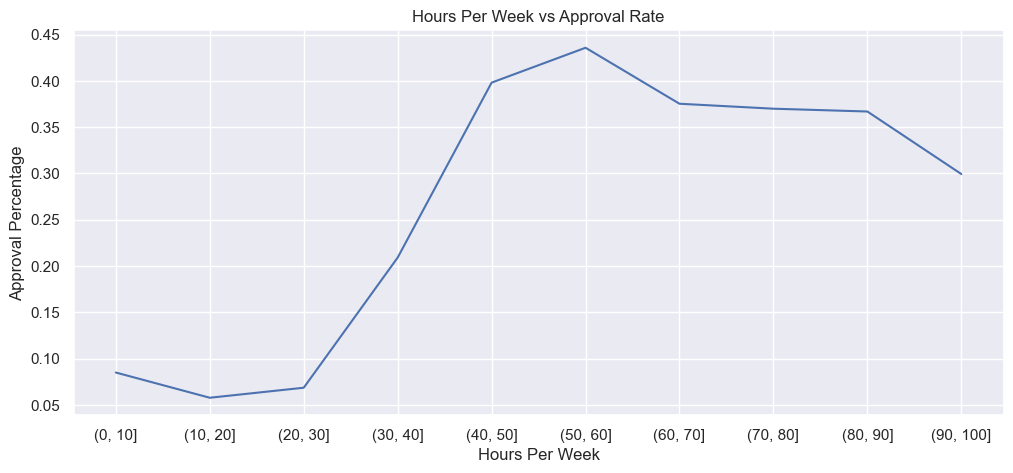

In [34]:
credit_data['hours_per_week_bins']=pd.cut(credit_data['hours_per_week'],[0,10,20,30,40,50,60,70,80,90,100])
hours_per_week_buckets=credit_data.groupby(['hours_per_week_bins'])['approved'].mean().reset_index()
hours_per_week_buckets["hours_per_week_bins"] = hours_per_week_buckets['hours_per_week_bins'].astype(str) 
hours_per_week_buckets['approved'] = hours_per_week_buckets['approved'].astype(float)

sns.lineplot(hours_per_week_buckets,x="hours_per_week_bins", y="approved", err_style="bars")

plt.title("Hours Per Week vs Approval Rate")
plt.ylabel("Approval Percentage")
plt.xlabel("Hours Per Week") 
plt.show()

In [35]:
display(credit_data.groupby(['hours_per_week_bins'])["occupation"].agg(lambda x:x.value_counts().index[0]).reset_index())

,hours_per_week_bins,occupation
0,"(0, 10]",Other-service
1,"(10, 20]",Other-service
2,"(20, 30]",Other-service
3,"(30, 40]",Craft-repair
4,"(40, 50]",Exec-managerial
5,"(50, 60]",Exec-managerial
6,"(60, 70]",Exec-managerial
7,"(70, 80]",Prof-specialty
8,"(80, 90]",Farming-fishing
9,"(90, 100]",Farming-fishing


<b>Observation :<br>
    
    We observe that as number of work hours increases per week approval percentage also increase 
    On further analysis we found the buckets where approval percentage is high we have Managerial & Prof-Speciality roles 
    which are educated section and also earns more than the other classes 

# Extracting Information From Address 

In [36]:
credit_data['state_name']=credit_data['address'].apply(lambda x :usaddress.parse(x)[-2][0])
credit_data['zipcode']=credit_data['address'].apply(lambda x :usaddress.parse(x)[-1][0])

In [37]:
usaddress.parse(credit_data['address'].iloc[0])

[('45424', 'AddressNumber'),
 ('Norris', 'StreetName'),
 ('Common', 'StreetNamePostType'),
 ('Apt.', 'OccupancyType'),
 ('390\n', 'OccupancyIdentifier'),
 ('North', 'PlaceName'),
 ('Mike,', 'PlaceName'),
 ('AR', 'StateName'),
 ('83962', 'ZipCode')]

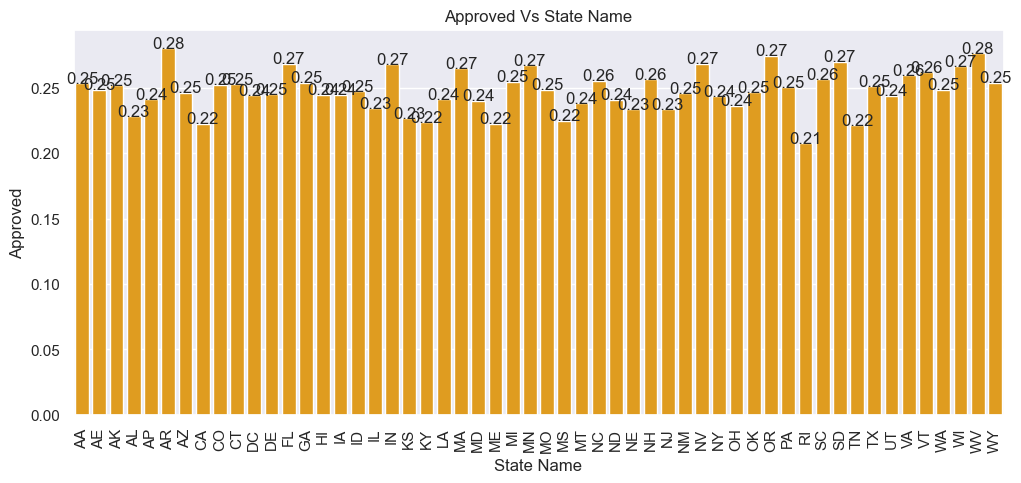

In [38]:
sns.set(rc={'figure.figsize':(80,5)})
generatePlots(credit_data.copy(),"state_name","approved","orange",90,None)

<b> Even though we are successfully able to capture the state name from the address , we observe all the states are having almost similar aproval rate 

# Extracting Information from Email 

In [39]:
credit_data['email_domain']=credit_data['email'].apply(lambda x: re.search("@[\w.]+", x).group().replace("@","").split(".")[-1])
credit_data['email_company']=credit_data['email'].apply(lambda x: re.search("@[\w.]+", x).group().replace("@",""))

In [40]:
### Converting less frequent one to others 
credit_data['email_domain']=np.where(credit_data['email_domain'].isin(['com',
 'org',
 'biz',
 'info',
 'net',]),credit_data['email_domain'],"others")

credit_data['email_company']=np.where(credit_data['email_company'].isin(['gmail.com',
 'yahoo.com',
 'hotmail.com',]),credit_data['email_company'],"others")

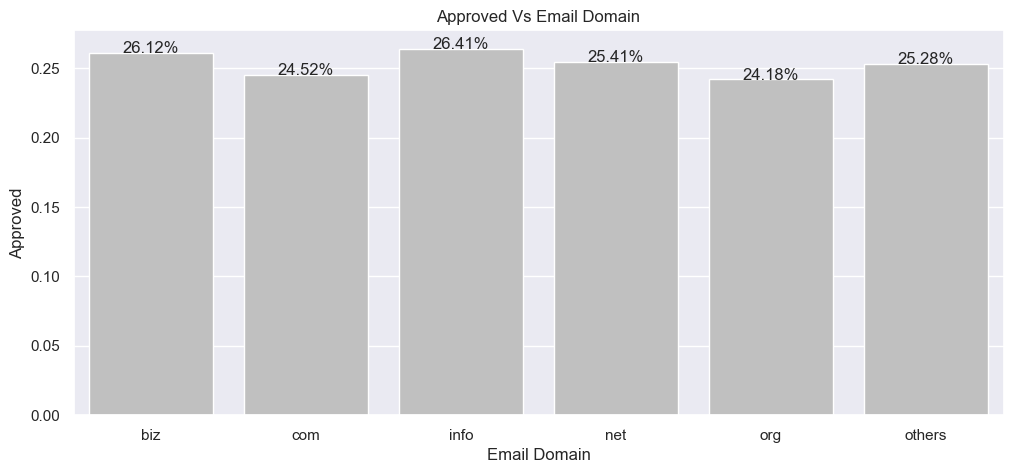

In [41]:
generatePlots(credit_data.copy(),"email_domain","approved","silver",0)

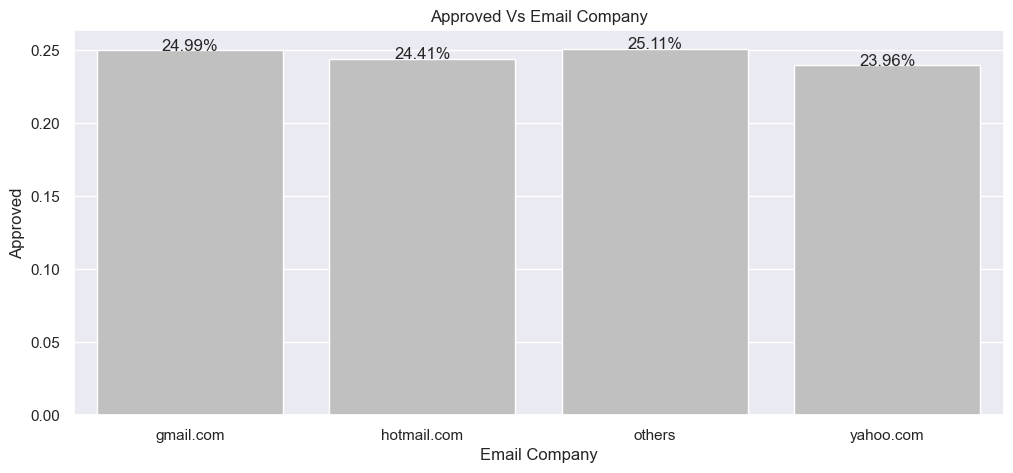

In [42]:
generatePlots(credit_data.copy(),"email_company","approved","silver",0)

<b> We observe almost all the email domains as well as compaines they are working with have almost similar approval rate 

# Inquiry Purpose Code vs Approved

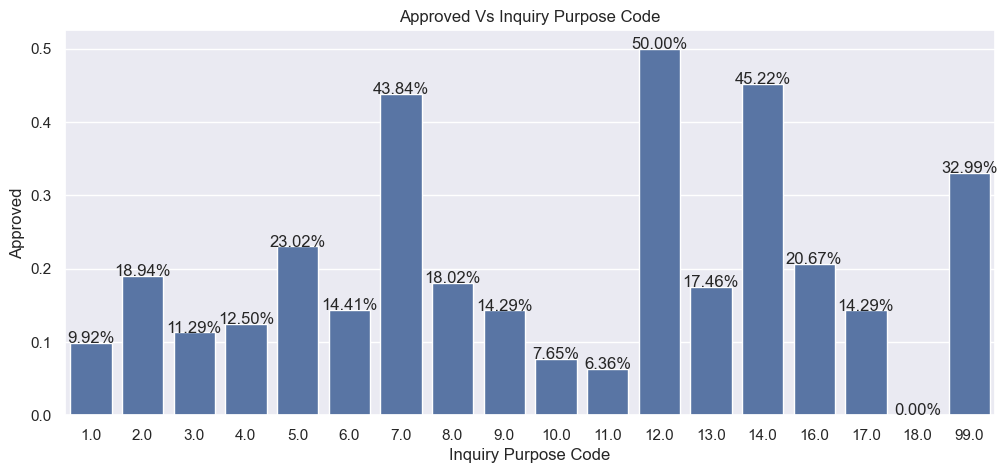

In [43]:
generatePlots(credit_data.copy(),"inquiry_purpose_code","approved","b",0)

<b>Some of the inquiries like Non-Funded Credit facility, credit card, and property loan has higher approval rate than others 

# Type of Institution vs Approved

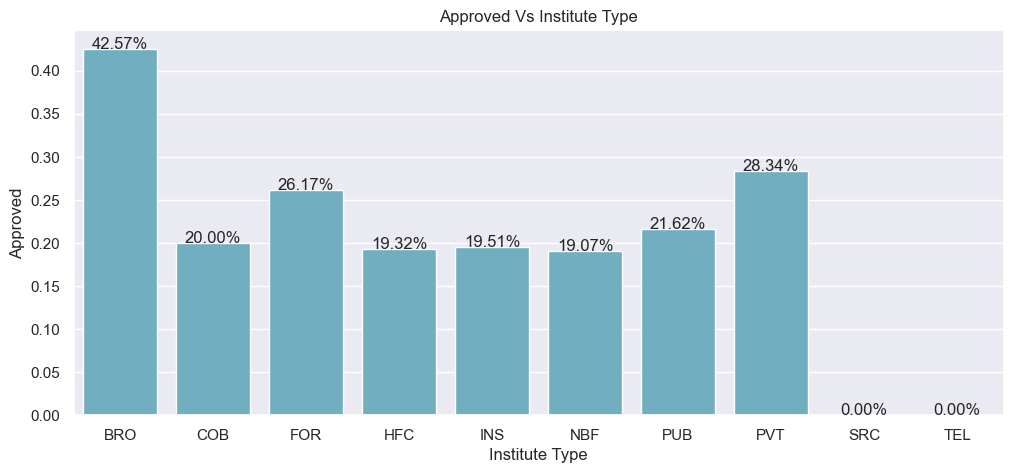

In [44]:
generatePlots(credit_data.copy(),"institute_type","approved","c",0)

<b> BRO is clearling leading in percetnage of applications geeting approved

# Asset Class vs Approved 

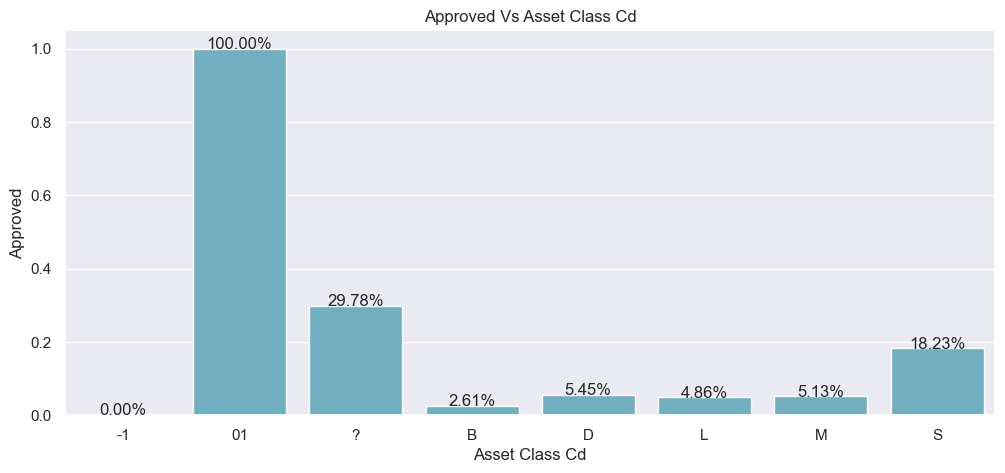

In [45]:
generatePlots(credit_data.copy(),"asset_class_cd","approved","c",0)

<b> We observe a lot of nulls here also 01 and -1 showing extreme percentage because we only have 1 record for them 

## Imputation of Asset Class

In [46]:
# credit_data.groupby(["asset_code","occupation"])['asset_class_cd'].describe()
mode_function = lambda x: np.nan if x.isnull().all() else x.value_counts().index[0]
mode_df = credit_data.groupby(["asset_code",'institute_type',"occupation"])['asset_class_cd'].apply(mode_function).reset_index()


In [47]:
credit_data['asset_class_cd']=credit_data['asset_class_cd'].fillna(credit_data['asset_class_cd'].value_counts().index[0])

<b>I have tried to look the variation of asset codes using different sub-groups, but most of the iteration resulted in data frame with mostly S class 

# Asset Code Vs Approved

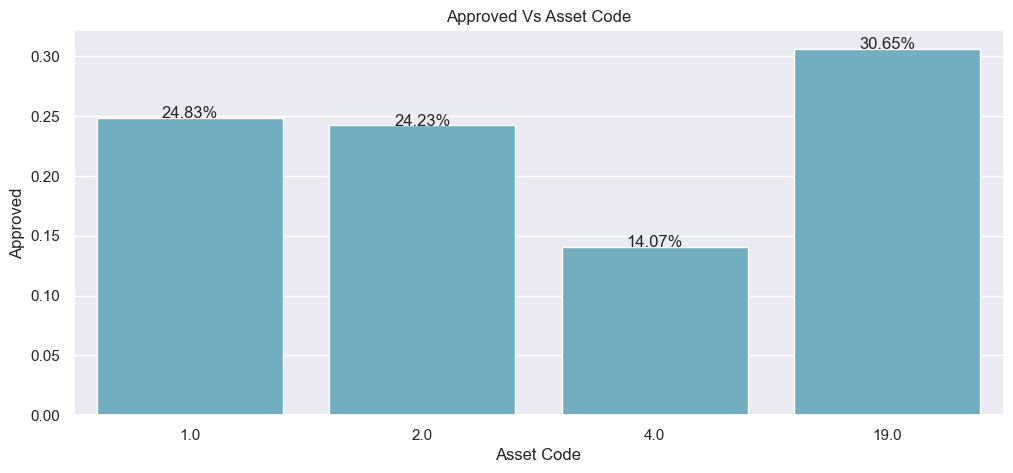

In [48]:
generatePlots(credit_data.copy(),"asset_code","approved","c",0)

<b>Authorised users have more approval rate while Guarantos have the least 

# PortFolio Type vs Approved 

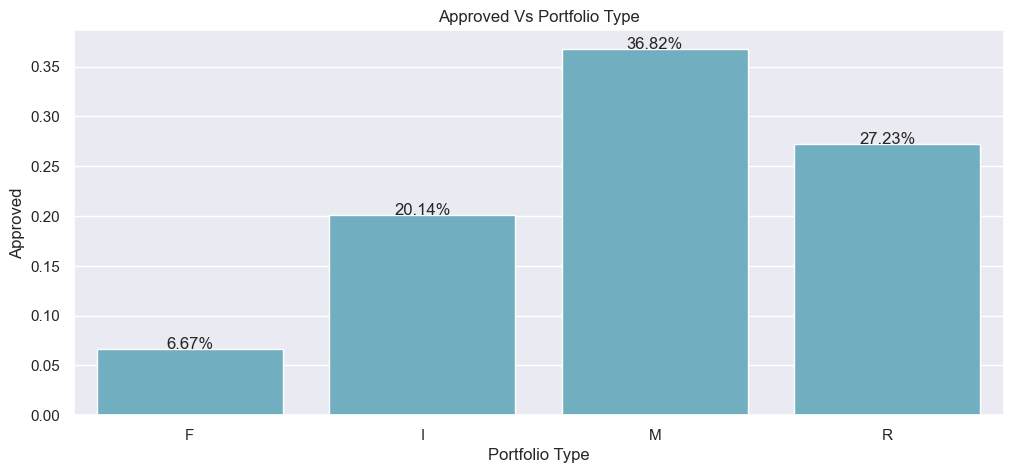

In [49]:
generatePlots(credit_data.copy(),"portfolio_type","approved","c",0)

<b>Motgage portfolio type has the highest approval percentage while microfinance has the lowest among all

# Feature Engineering (1/2)

<b>Following types of feature will be created : 
1) Extracting age from the date of birth and diviving it into different bins<br>
2) Calculating net profit from capital gain and capital loss  <br>
3) Finding if capital gain and capital loss is 0 or any other positive number <br>4) Extracting Microfinance or Priority Sector information <br>
5) Defining dropout vs non-dropout <br>
6) Interaction of Domain with Occupation <br>
7) Extracting domain and company from email address <br>
8) Extracting name of the state from Address <br>
9) Label Encoding <br>
10) Target Encoding <br>
11) Direct Features <br>

In [74]:

########### Target Encoding ############################################

def meanEncoding(column_names,features,target,train,test,validation,regularisation=True):    
    for i in column_names: 
        item_id_target_mean = train.groupby(i)[target].mean()
        with open(f'model_artifacts/target_encoding_{i}.pkl', 'wb') as f:
            pickle.dump(item_id_target_mean, f)
        if regularisation==False:
            train[i+"_mean_encoding"] = train[i].map(item_id_target_mean)
        else:
            skf = StratifiedKFold(n_splits=3)
            train[i+"_mean_encoding"] = 0
            features=features+[i+"_mean_encoding"]
            for tr_ind, val_ind in skf.split(train[features],train[target]):
                X_tr, X_val = train.iloc[tr_ind], train.iloc[val_ind]
                X_val[i+"_mean_encoding"] = X_val[i].map(X_tr.groupby(i)[target].mean())

                train.iloc[val_ind]["_mean_encoding"]=X_val[i+"_mean_encoding"]
        fillnan=train[target].mean()
        test[i+"_mean_encoding"]=test[i].map(item_id_target_mean)
        validation[i+"_mean_encoding"]=validation[i].map(item_id_target_mean)
             
    train.reset_index(inplace=True,drop=True)
    validation.reset_index(inplace=True,drop=True)
    test.reset_index(inplace=True,drop=True)        
    return train,test,validation   


##################### Label Encoding #######################################

def labelEncoding(column_names,train,test,validation):
    le = LabelEncoder()
    for i in column_names:
        train[i+'_label_encoded']=le.fit_transform(train[i]) 
        joblib.dump(le, f'model_artifacts/label_encoder_{i}.joblib')
        test[i+"_label_encoded"]=le.transform(test[i])
        validation[i+"_label_encoded"]=le.transform(validation[i])
        train.reset_index(inplace=True,drop=True)
        validation.reset_index(inplace=True,drop=True)
        test.reset_index(inplace=True,drop=True)
    return train,test,validation

## Capital Gain is Zero & Capital Loss is Zero 

In [55]:
credit_data['capital_gain_is_zero'] = np.where(credit_data['capital_gain']<=0,0,1)
credit_data['capital_loss_is_Zero'] = np.where(credit_data['capital_loss']>0,1,0)

##  Dropouts vs Non-Dropouts

In [56]:
credit_data['education_level'].unique()

array([' 11th', ' Some-college', ' HS-grad', ' Masters', ' 12th',
       ' Bachelors', ' Assoc-voc', ' Assoc-acdm', ' 9th', ' 7th-8th',
       ' 10th', ' Prof-school', ' 5th-6th', ' Doctorate', ' 1st-4th',
       ' Preschool'], dtype=object)

In [57]:
credit_data['droput_vs_non_dropout']=credit_data['education_level'].apply(lambda x: 1 if x in [' 11th',' 9th', ' 7th-8th',
       ' 10th', ' 5th-6th', ' 1st-4th',
       ' Preschool'] else 0)

# Creating Train, Validation and Test 

In [58]:
train, test = train_test_split(credit_data, test_size=0.15, random_state=1,stratify=credit_data['approved'])
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

### Validation Data 
train, validation = train_test_split(train, test_size=0.10, random_state=1,stratify=train['approved'])
validation.reset_index(inplace=True,drop=True)
train.reset_index(inplace=True,drop=True)

print("Shape for Train : " + str(train.shape), "Default Rate : "+str(np.round(train['approved'].mean(),2)))
print("Shape for Validation : " + str(validation.shape), "Default Rate : "+str(np.round(validation['approved'].mean(),2)))
print("Shape for Test : " + str(test.shape), "Default Rate : "+str(np.round(test['approved'].mean(),2)))



Shape for Train : (34594, 35) Default Rate : 0.25
Shape for Validation : (3844, 35) Default Rate : 0.25
Shape for Test : (6784, 35) Default Rate : 0.25


# Feature Engineering (2/2)

## Label Encoding 

In [59]:
columns_for_label_encoding=["workclass","education_level","education_num","marital_status","occupation","relationship"
                           ,"email_domain","email_company","inquiry_purpose_code","institute_type","asset_class_cd","asset_code"
                            ,"portfolio_type"]

In [61]:
train,test,validation=labelEncoding(columns_for_label_encoding,train,test,validation)

## Target Encoding Binned Variables 

In [68]:
columns_for_target_encoding=["hours_per_week_bins","age_bins","zipcode","state_name","account_type"]

In [75]:
train,test,validation=meanEncoding(columns_for_target_encoding,train.columns.tolist(),"approved",train,test,validation,False)

# Feature Selection 

In [76]:
train.columns

Index(['user_id', 'gender', 'date_of_birth', 'workclass', 'education_level',
       'education_num', 'marital_status', 'occupation', 'relationship',
       'capital_gain', 'capital_loss', 'hours_per_week', 'approved', 'address',
       'email', 'inquiry_purpose_code', 'institute_type', 'account_type',
       'asset_class_cd', 'asset_code', 'portfolio_type', 'age_of_applicant',
       'age_bins', 'capital_gain_bins', 'capital_loss_bins', 'capital_profit',
       'capital_is_zero', 'hours_per_week_bins', 'state_name', 'zipcode',
       'email_domain', 'email_company', 'capital_gain_is_zero',
       'capital_loss_is_Zero', 'droput_vs_non_dropout',
       'workclass_label_encoded', 'education_level_label_encoded',
       'education_num_label_encoded', 'marital_status_label_encoded',
       'occupation_label_encoded', 'relationship_label_encoded',
       'email_domain_label_encoded', 'email_company_label_encoded',
       'inquiry_purpose_code_label_encoded', 'institute_type_label_encoded',


In [80]:
## removed education level as it was correlated to education num,
## removed zip code because of too many categories 
## removed capital gain and capital loss as we have dervied some features from them 
universal_feature_set=['capital_gain_is_zero', 'capital_loss_is_Zero', 'droput_vs_non_dropout', 'workclass_label_encoded',
       'education_num_label_encoded',
       'marital_status_label_encoded', 'occupation_label_encoded',
       'relationship_label_encoded',
       'email_domain_label_encoded', 'email_company_label_encoded',
       'inquiry_purpose_code_label_encoded', 'institute_type_label_encoded',
       'asset_class_cd_label_encoded', 'asset_code_label_encoded',
       'portfolio_type_label_encoded', 'hours_per_week_bins_mean_encoding',
       'age_bins_mean_encoding',
       'state_name_mean_encoding', 'account_type_mean_encoding','capital_profit','age_of_applicant']

In [81]:
len(universal_feature_set)

21

## Correlation Analysis 

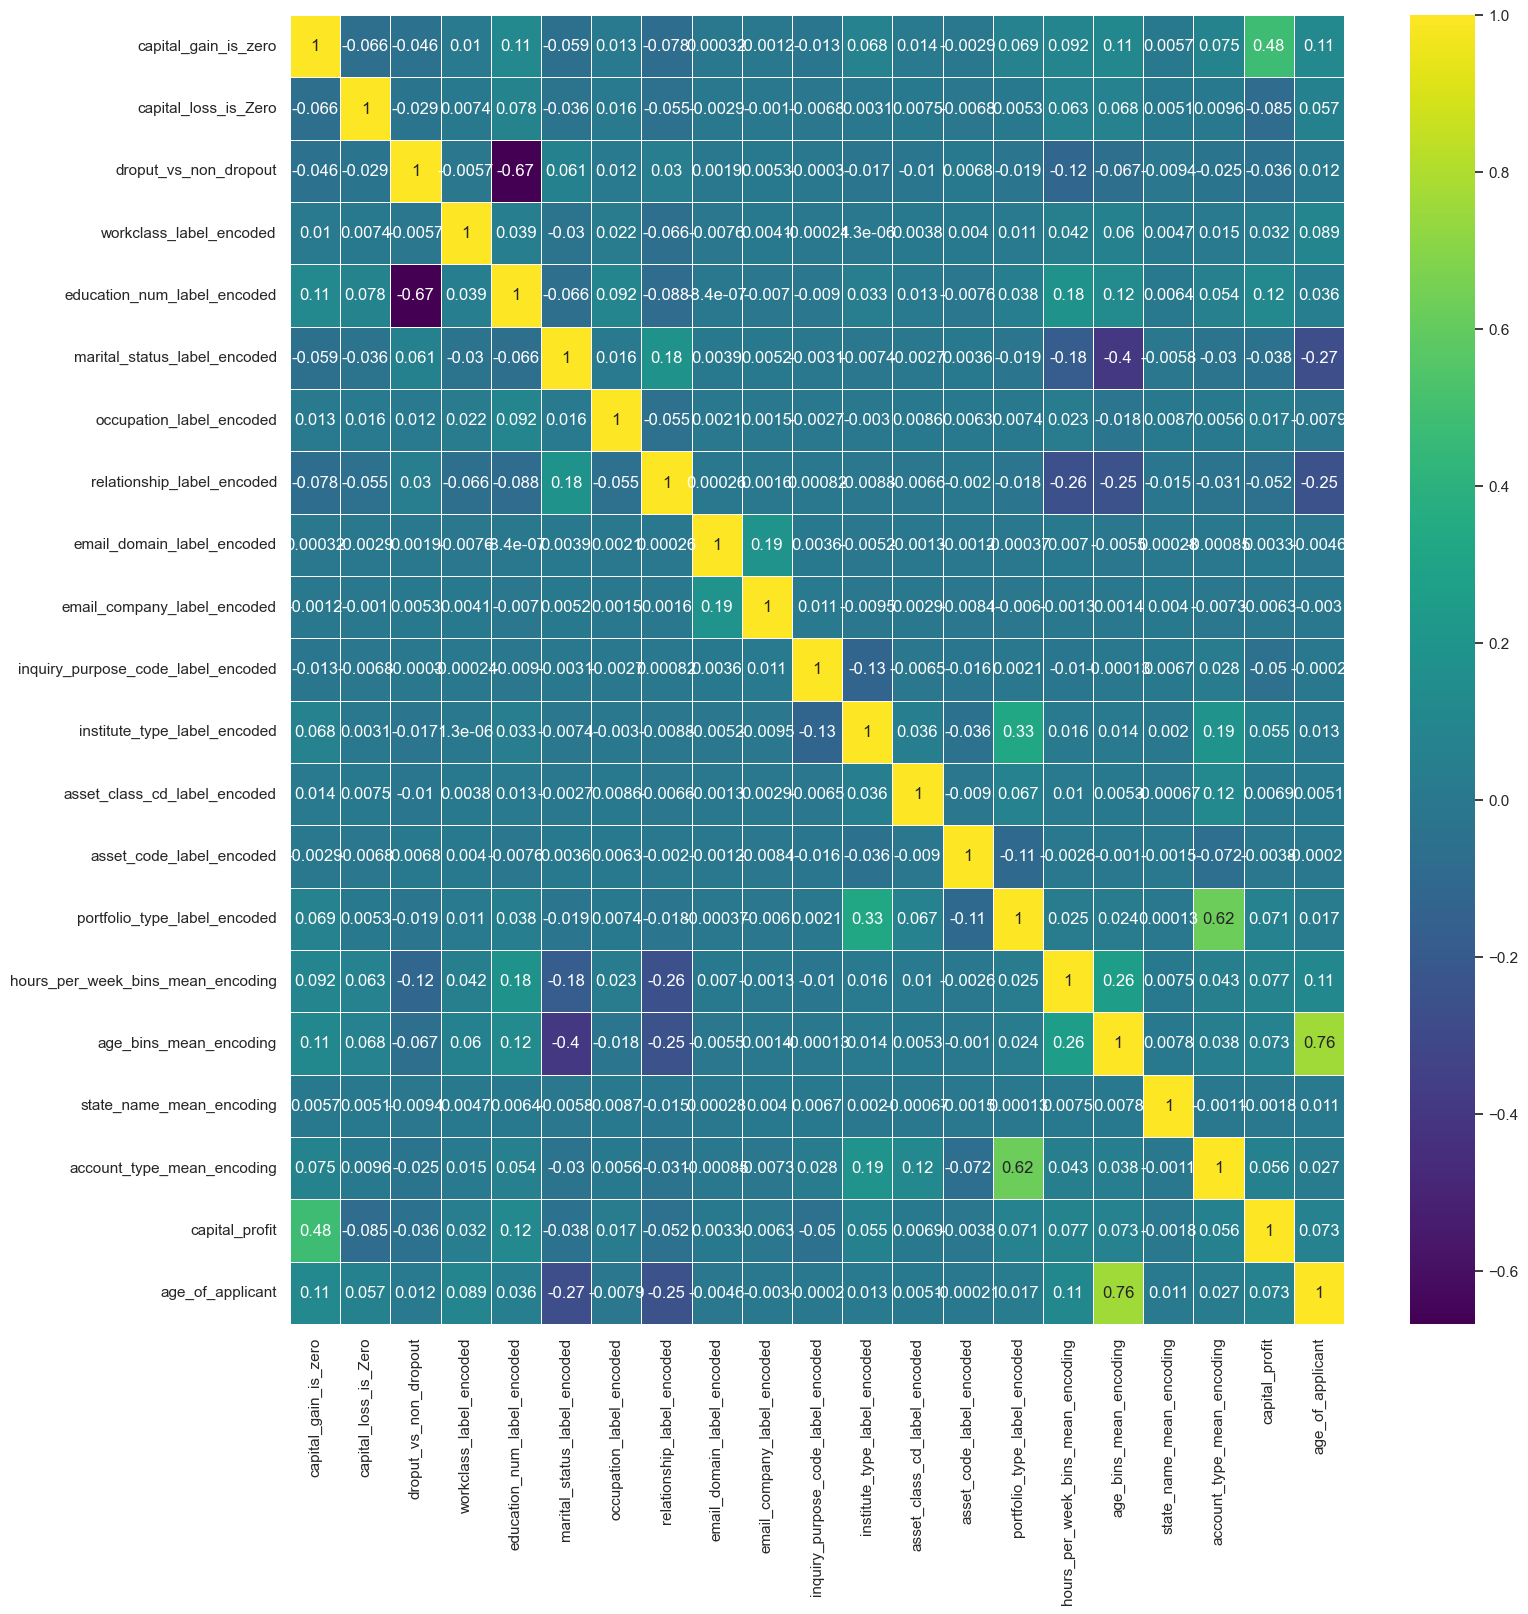

In [82]:
corremat = train[universal_feature_set].corr()
plt.figure(figsize=(17,17))
g=sns.heatmap(train[universal_feature_set].corr(),annot=True,cmap='viridis',linewidths=.5)

<b>
1) Account Type and Portfolio Type is highly correlated <br>
2) Dropout vs Non Dropout is highly related to both Education lev and Educated num 

# Backward Feature Selection 

In [83]:
clf = DecisionTreeClassifier(random_state=1)
recursive_eliminator = RFECV(clf,cv=StratifiedKFold(3),min_features_to_select=10,step=2,scoring="f1")
recursive_eliminator.fit(train[universal_feature_set], train['approved'])

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(random_state=1),
      min_features_to_select=10, scoring='f1', step=2)

In [84]:
columns_retained_RFECV = train[universal_feature_set].columns[recursive_eliminator.get_support()].values

In [85]:
columns_retained_RFECV

array(['capital_gain_is_zero', 'capital_loss_is_Zero',
       'workclass_label_encoded', 'education_num_label_encoded',
       'marital_status_label_encoded', 'occupation_label_encoded',
       'relationship_label_encoded', 'email_domain_label_encoded',
       'email_company_label_encoded',
       'inquiry_purpose_code_label_encoded',
       'institute_type_label_encoded', 'asset_code_label_encoded',
       'portfolio_type_label_encoded',
       'hours_per_week_bins_mean_encoding', 'age_bins_mean_encoding',
       'state_name_mean_encoding', 'account_type_mean_encoding',
       'capital_profit', 'age_of_applicant'], dtype=object)

In [86]:
columns_retained_RFECV

array(['capital_gain_is_zero', 'capital_loss_is_Zero',
       'workclass_label_encoded', 'education_num_label_encoded',
       'marital_status_label_encoded', 'occupation_label_encoded',
       'relationship_label_encoded', 'email_domain_label_encoded',
       'email_company_label_encoded',
       'inquiry_purpose_code_label_encoded',
       'institute_type_label_encoded', 'asset_code_label_encoded',
       'portfolio_type_label_encoded',
       'hours_per_week_bins_mean_encoding', 'age_bins_mean_encoding',
       'state_name_mean_encoding', 'account_type_mean_encoding',
       'capital_profit', 'age_of_applicant'], dtype=object)

In [87]:
len(columns_retained_RFECV)

19

## Manually choosing the right set of features from auto selected features

In [88]:
universal_feature_set = ['capital_gain_is_zero', 'capital_loss_is_Zero',
       'workclass_label_encoded',
       'education_num_label_encoded', 'marital_status_label_encoded',
       'occupation_label_encoded', 'relationship_label_encoded',
       'asset_code_label_encoded',
       'capital_profit', 'age_of_applicant']

In [89]:
len(universal_feature_set)

10

In [73]:
import json 
temp_df= credit_data[['workclass','education_num','marital_status','occupation','relationship','asset_code']]
unique_values_dict = {col: af[col].unique().tolist() for col in temp_df.columns}
unique_values_json = json.dumps(unique_values_dict)
with open('../model_artifacts/categorical_column_unique_values.pkl', 'wb') as f:
    pickle.dump(unique_values_dict, f)

# Modelling 

In [90]:
def plotROCAUCCurve(y_train, y_train_pred, y_validation, y_validation_pred,y_test, y_test_pred):
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    validation_fpr, validation_tpr, te_thresholds = roc_curve(y_validation, y_validation_pred)
    
    calcAUC = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    
    plt.plot(validation_fpr, validation_tpr, label="validation AUC ="+str(auc(validation_fpr, validation_tpr)))
    
    
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    
    
    
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    
    plt.title("ROC Curve for Train and Validation and Test set")
    
    plt.grid()
    plt.show()
    return calcAUC

In [91]:
def evaluate_metrics(y_true,y_pred,model_name):
    
    classification_metrics={}
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    classification_metrics['model_name']=model_name
    classification_metrics["roc_auc"]=(roc_auc_score(y_true, y_pred))
    classification_metrics['au_prc'] = average_precision_score(y_true, y_pred)
    classification_metrics['brier_score']=brier_score_loss(y_true, y_pred)
    
    ### optimal Threshold#########
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    y_pred=np.where(y_pred>optimal_threshold,1,0)
    
    classification_metrics['recall_score']=recall_score(y_true,y_pred)
    classification_metrics['precision_score']=precision_score(y_true, y_pred)
    classification_metrics['f1_score']=f1_score(y_true, y_pred)
    classification_metrics['optimal_threshold']=optimal_threshold if optimal_threshold != np.inf else 1
    
    
    
    return pd.DataFrame([classification_metrics],columns=classification_metrics.keys())

## Base Model : Predicting Majority Class

In [92]:
target="approved"

In [93]:
base_model_metrics_validation=evaluate_metrics(validation[target].tolist(),[1]*len(validation),"base_model_validation")
base_model_metrics_test=evaluate_metrics(test[target].tolist(),[1]*len(test),"base_model_test")
base_model_metrics_train=evaluate_metrics(train[target].tolist(),[1]*len(train),"base_model_train")

In [94]:
base_model_results=pd.concat([base_model_metrics_train,base_model_metrics_validation,base_model_metrics_test], ignore_index=True)
base_model_results

,model_name,roc_auc,au_prc,brier_score,recall_score,precision_score,f1_score,optimal_threshold
0,base_model_train,0.5,0.247846,0.752154,0.0,0.0,0.0,1
1,base_model_validation,0.5,0.247919,0.752081,0.0,0.0,0.0,1
2,base_model_test,0.5,0.247789,0.752211,0.0,0.0,0.0,1


## XGboost with Optuna Hyper-Parameter Tuning and Universal Feature List 

In [95]:
def objective(X_train, y_train, X_test, y_test, trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 300)  
    max_depth = trial.suggest_int('max_depth', 4, 8)
    min_child_weight = trial.suggest_int('min_child_weight', 7, 29)
    learning_rate = trial.suggest_discrete_uniform('learning_rate', 0.01, 0.5, 0.01)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1,5)
    subsample = trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.6, 1.0, 0.1)
    colsample_bynode = trial.suggest_discrete_uniform('colsample_bynode', 0.6, 1.0, 0.1)
    colsample_bylevel = trial.suggest_discrete_uniform('colsample_bylevel', 0.6, 1.0, 0.1)
    reg_alpha=trial.suggest_int('reg_alpha', 1, 5)
    gamma=trial.suggest_int('gamma', 1, 5)
    reg_lambda=trial.suggest_int('reg_lambda', 1, 5)

    xgboost_tuna = xgb.XGBClassifier(n_jobs=1,
        random_state=1, 
        tree_method='hist',
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        learning_rate = learning_rate,
        scale_pos_weight = scale_pos_weight,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        colsample_bynode = colsample_bynode,
        colsample_bylevel = colsample_bylevel,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        gamma=gamma
                                     
        
                                             
    )
    xgboost_tuna.fit(X_train, y_train)
    tuna_pred_test_proba = xgboost_tuna.predict_proba(X_test)[:,1]
    return (1.0 - (roc_auc_score(y_test, tuna_pred_test_proba)))


In [96]:
study = optuna.create_study()
study.optimize(functools.partial(objective, train[universal_feature_set].astype(float), train[target], validation[universal_feature_set].astype(float),validation[target] ), n_trials=20)

[I 2024-07-28 19:24:03,228] A new study created in memory with name: no-name-92f22e89-0c20-4301-accd-218cb0dde2b7
[I 2024-07-28 19:24:04,755] Trial 0 finished with value: 0.07914909788056645 and parameters: {'n_estimators': 266, 'max_depth': 6, 'min_child_weight': 14, 'learning_rate': 0.37, 'scale_pos_weight': 3, 'subsample': 0.7, 'colsample_bytree': 0.8, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.6, 'reg_alpha': 4, 'gamma': 2, 'reg_lambda': 5}. Best is trial 0 with value: 0.07914909788056645.
[I 2024-07-28 19:24:06,212] Trial 1 finished with value: 0.07881281525362027 and parameters: {'n_estimators': 246, 'max_depth': 7, 'min_child_weight': 23, 'learning_rate': 0.11, 'scale_pos_weight': 4, 'subsample': 0.9, 'colsample_bytree': 0.8, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.8, 'reg_alpha': 3, 'gamma': 3, 'reg_lambda': 1}. Best is trial 1 with value: 0.07881281525362027.
[I 2024-07-28 19:24:07,825] Trial 2 finished with value: 0.07708385433245635 and parameters: {'n_estimator

In [103]:
params=study.best_params
xgb_v1 = XGBClassifier(random_state=1,**params)
xgb_v1.fit(train[universal_feature_set].astype(float),train[target])
joblib.dump(xgb_v1,"model_artifacts/xgboost_v1.joblib")

['model_artifacts/xgboost_v1.joblib']

In [104]:
xgb_universal_features_model_metrics_validation=evaluate_metrics(validation[target],xgb_v1.predict_proba(validation[universal_feature_set].astype(float))[:,1],"xgb_universal_features_validation")
xgb_universal_features_model_metrics_test=evaluate_metrics(test[target],xgb_v1.predict_proba(test[universal_feature_set].astype(float))[:,1],"xgb_universal_features_test")
xgb_universal_features_model_metrics_train=evaluate_metrics(train[target],xgb_v1.predict_proba(train[universal_feature_set].astype(float))[:,1],"xgb_universal_features_train")

xgb_universal_results=pd.concat([xgb_universal_features_model_metrics_train,xgb_universal_features_model_metrics_validation,xgb_universal_features_model_metrics_test], ignore_index=True)
xgb_universal_results

,model_name,roc_auc,au_prc,brier_score,recall_score,precision_score,f1_score,optimal_threshold
0,xgb_universal_features_train,0.971793,0.925087,0.059679,0.927922,0.725251,0.814163,0.282860
1,xgb_universal_features_validation,0.914686,0.811339,0.099036,0.898216,0.550837,0.682888,0.149802
2,xgb_universal_features_test,0.907199,0.795523,0.103929,0.851279,0.567407,0.680942,0.209154


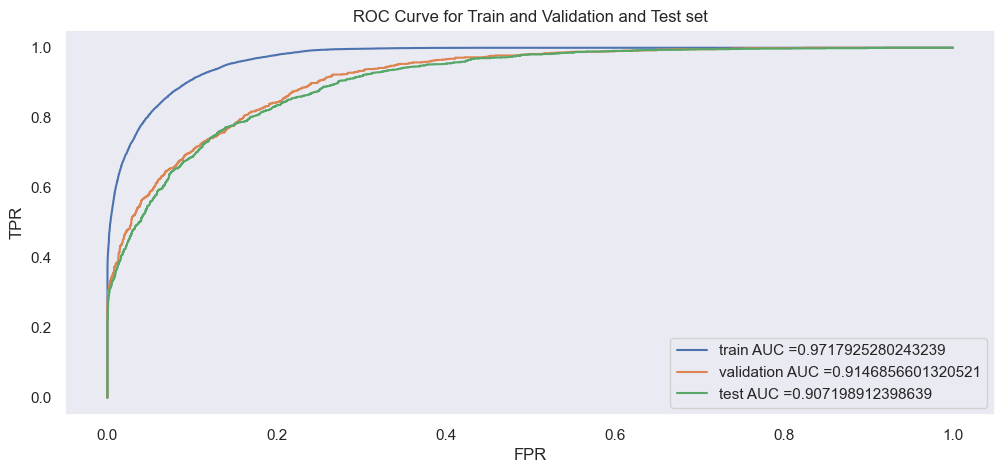

0.907198912398639

In [105]:
plotROCAUCCurve(train[target],xgb_v1.predict_proba(train[universal_feature_set].astype(float))[:,1],validation[target],xgb_v1.predict_proba(validation[universal_feature_set].astype(float))[:,1],test[target],xgb_v1.predict_proba(test[universal_feature_set].astype(float))[:,1])

## Random Forest with Optuna Universal Features

In [106]:
def objective_rf(X_train, y_train, X_test, y_test, trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 7, 25),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1,35),
        'max_features' : trial.suggest_discrete_uniform('max_features', 0.6, 1.0, 0.1)
    }

    rf_tuna = RandomForestClassifier(random_state=1, **params)
    rf_tuna.fit(X_train, y_train)

    tuna_pred_test_proba = rf_tuna.predict_proba(X_test)[:,1]
    return (1.0 - (roc_auc_score(y_test, tuna_pred_test_proba)))

In [107]:
study = optuna.create_study()
study.optimize(functools.partial(objective_rf, train[universal_feature_set].astype(float), train[target], validation[universal_feature_set].astype(float).fillna(0),validation[target]), n_trials=15)

[I 2024-07-28 19:27:57,817] A new study created in memory with name: no-name-3c7b1b82-0fe9-4084-9ea6-66a3fed55ed5
[I 2024-07-28 19:28:03,060] Trial 0 finished with value: 0.1065219229776675 and parameters: {'n_estimators': 261, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 0.6}. Best is trial 0 with value: 0.1065219229776675.
[I 2024-07-28 19:28:05,395] Trial 1 finished with value: 0.10112198257573246 and parameters: {'n_estimators': 94, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 0.7}. Best is trial 1 with value: 0.10112198257573246.
[I 2024-07-28 19:28:08,782] Trial 2 finished with value: 0.09053062240778353 and parameters: {'n_estimators': 109, 'max_depth': 8, 'min_samples_split': 25, 'min_samples_leaf': 19, 'max_features': 0.6}. Best is trial 2 with value: 0.09053062240778353.
[I 2024-07-28 19:28:17,611] Trial 3 finished with value: 0.08763474443790709 and parameters: {'n_estimators': 266, 'max_depth': 9, 'min_s

In [108]:
params=study.best_params
params['class_weight']={0:1,1:1}
rf_v1 = RandomForestClassifier(random_state=1,**params)
rf_v1.fit(train[universal_feature_set].astype(float),train[target])
joblib.dump(rf_v1,"model_artifacts/random_forest_v1.joblib")

['model_artifacts/random_forest_v1.joblib']

In [109]:
rf_universal_features_model_metrics_validation=evaluate_metrics(validation[target],rf_v1.predict_proba(validation[universal_feature_set].astype(float).fillna(0))[:,1],"rf_universal_features_validation")
rf_universal_features_model_metrics_test=evaluate_metrics(test[target],rf_v1.predict_proba(test[universal_feature_set].astype(float).fillna(0))[:,1],"rf_universal_features_test")
rf_universal_features_model_metrics_train=evaluate_metrics(train[target],rf_v1.predict_proba(train[universal_feature_set].astype(float).fillna(0))[:,1],"rf_universal_features_train")
rf_universal_results=pd.concat([rf_universal_features_model_metrics_train,rf_universal_features_model_metrics_validation,rf_universal_features_model_metrics_test], ignore_index=True)
rf_universal_results

,model_name,roc_auc,au_prc,brier_score,recall_score,precision_score,f1_score,optimal_threshold
0,rf_universal_features_train,0.922028,0.822185,0.093561,0.866573,0.596883,0.706879,0.254851
1,rf_universal_features_validation,0.914072,0.810162,0.097062,0.838405,0.608994,0.705519,0.284614
2,rf_universal_features_test,0.907501,0.797818,0.100596,0.814396,0.596774,0.688805,0.308245


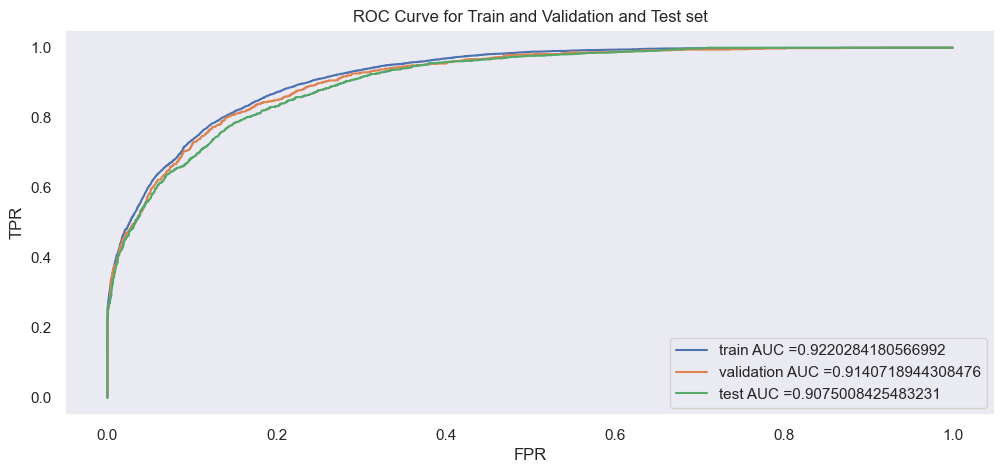

0.9075008425483231

In [110]:
plotROCAUCCurve(train[target],rf_v1.predict_proba(train[universal_feature_set].astype(float))[:,1],validation[target],rf_v1.predict_proba(validation[universal_feature_set].astype(float).fillna(0))[:,1],test[target],rf_v1.predict_proba(test[universal_feature_set].astype(float).fillna(0))[:,1])

### Feature Importance 

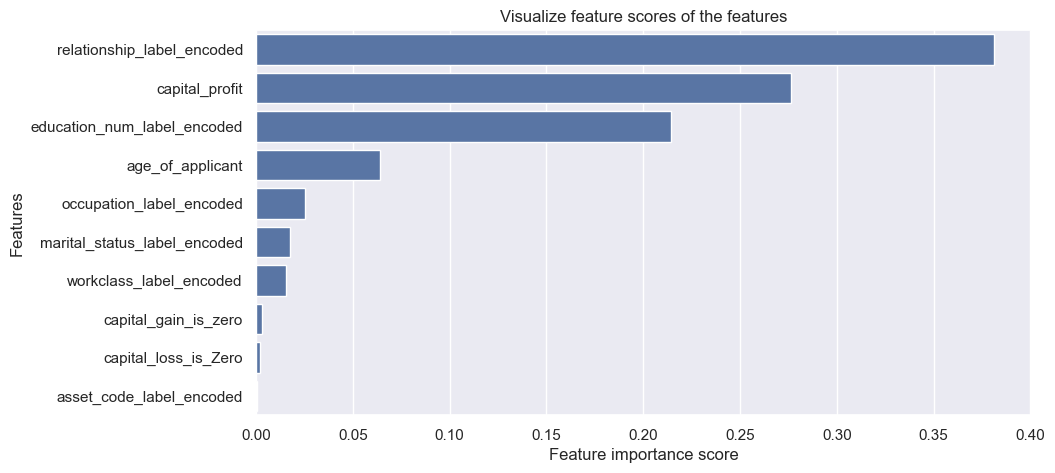

In [111]:
feature_scores = pd.Series(rf_v1.feature_importances_, index=train[universal_feature_set].columns).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

# Summarizing the Modelling Results 

In [112]:
model_results_summary=pd.concat([base_model_results,xgb_universal_results,rf_universal_results], ignore_index=True)

In [113]:
model_results_summary

,model_name,roc_auc,au_prc,brier_score,recall_score,precision_score,f1_score,optimal_threshold
0,base_model_train,0.500000,0.247846,0.752154,0.000000,0.000000,0.000000,1.000000
1,base_model_validation,0.500000,0.247919,0.752081,0.000000,0.000000,0.000000,1.000000
2,base_model_test,0.500000,0.247789,0.752211,0.000000,0.000000,0.000000,1.000000
3,xgb_universal_features_train,0.971793,0.925087,0.059679,0.927922,0.725251,0.814163,0.282860
4,xgb_universal_features_validation,0.914686,0.811339,0.099036,0.898216,0.550837,0.682888,0.149802
5,xgb_universal_features_test,0.907199,0.795523,0.103929,0.851279,0.567407,0.680942,0.209154
6,rf_universal_features_train,0.922028,0.822185,0.093561,0.866573,0.596883,0.706879,0.254851
7,rf_universal_features_validation,0.914072,0.810162,0.097062,0.838405,0.608994,0.705519,0.284614
8,rf_universal_features_test,0.907501,0.797818,0.100596,0.814396,0.596774,0.688805,0.308245


<b> Observations : <br><br>
    1) In none of the models we have major difference between the scores of train, validation and test so we can say that 
    our models are not overfitting <br>
    2) All the models are performing similar on validation and test <br>
    3) Best model based on F1-Score using test data is XGboost... 

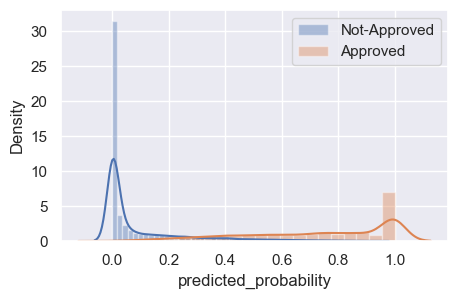

In [114]:
train_v2=train.copy()
test_v2=test.copy()
train_v2['predicted_probability']=xgb_v1.predict_proba(train_v2[universal_feature_set].astype(float).fillna(0))[:,1]
test_v2['predicted_probability']=xgb_v1.predict_proba(test_v2[universal_feature_set].astype(float).fillna(0))[:,1]
    


def get_seperation_plot(df):
    sns.set(rc={'figure.figsize':(5,3)})
    f, ax = plt.subplots(1, 1)
    sns.distplot(df[df[target]==0]['predicted_probability'],label="Not-Approved")
    sns.distplot(df[df[target]==1]['predicted_probability'],label="Approved")
    ax.legend()
    plt.show()
    

get_seperation_plot(train_v2.copy())

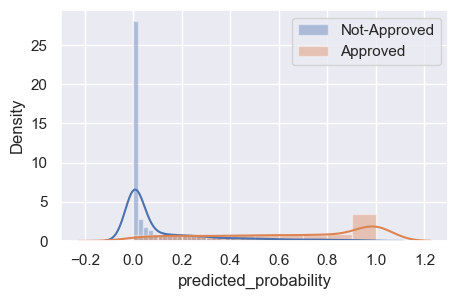

In [115]:
get_seperation_plot(test_v2.copy())

<b> We can observe that there is very clear seperation between the two classes 